# 7.3 신경망 모델 훈련

- 드롭아웃(dropout): 훈련과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉 뉴런의 출력을 0으로 만들어) 과대적합을 막음

- 콜백(callback): 케라스에서 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras, callbacks 패키지 아래에 있는 클래스로 fit() 메서드의 callback 매개변수에 리스트로 전달하여 사용

- 적응적 학습률(adaptive learning rate): 모델이 최적점에 가까이 갈수록 안정적으로 수렴하도록 학습률을 낮추도록 조정하는 방법.
이런 방식들은 학습률 매개변수를 튜닝하는 수고를 덜 수 있는 것이 장점.

- 조기종료

In [6]:
# 라이브러리 호출 및 데이터 준비
from tensorflow import keras        # 텐서플로를 사용해 데이터 불러오기
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 훈련세트와 검증세트로 나누기
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data() 
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled,
                                                                      train_target, test_size=0.2, random_state=42)

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
# 모델 만들기
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation = 'relu'))
    if a_layer:
        model.add(a_layer)
    # if 구문의 역할은 model_fn()함수에 (a_layer 매개변수로) 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

# 여기서는 a_layer 매개변수로 층을 추가하지 않고 단순하게 model_fn() 함수를 호출
# 모델 구조를 출력하면 이전 절과 같은 동일한 모델구조임을 확인 가능
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [8]:
# fit method의 결과를 history 변수에 담음.
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [9]:
# history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있음
print(history.history.keys())
    # 손실과 정확도가 나옴. 케라스는 기본적으로 에폭마다 손실을 계산함.
    # 정확도는 compile()메서드에서 metrics 매개변수에 'accuracy'를 추가했기 떄문에 history 속성에 포함됨.

dict_keys(['loss', 'accuracy'])


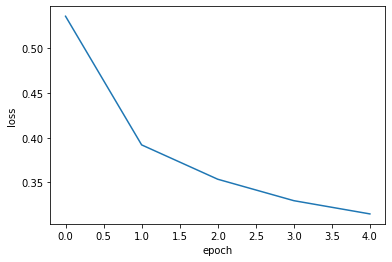

In [10]:
# history 속성에 포함된 손실과 정확도는 에폭마다 계산한 값이 순서대로 나열된 단순한 리스트
# 맷플롯립을 사용해 쉽게 그래프로 그려보기

# loss 보기
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

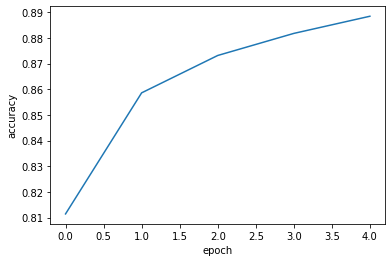

In [11]:
# accuracy 보기
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
# 검증 손실
    # 에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증세트에 대한 점수도 필요함
    # 따라서 훈련 세트와 검증세트의 그래프를 그리고자 함

# 에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit()메서드에 검증 데이터를 전달할 수 있음
# 다음처럼 validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달함
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [13]:
# 변환된 history.history 딕셔너리에 어떤 값이 들어 있는지 키 확인
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


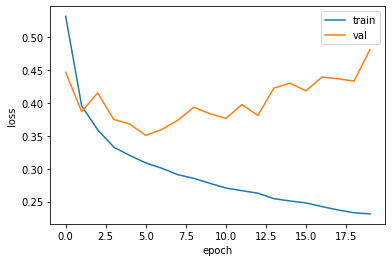

In [14]:
# 훈련 손실과 검증 손실을 한 그래프에 그려서 비교하기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
    # 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 
    # 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것

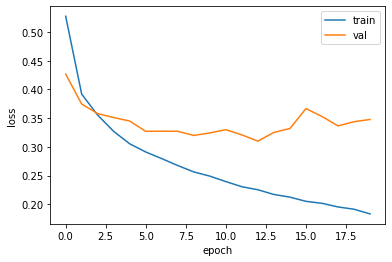

In [15]:
# 과대적합을 막는 신경망에 특화된 규제 방법
# 방법 1. 옵티마이저 하이퍼파라미터를 조정하여 과대적합 완화
#    -  기본 RMSprop 옵티마이저는 많은 문제에서 잘 동작
#    -  이 옵타미아저 대신 다른 옵티마이저를 테스트해 본다면 Adam이 가장 좋은 선택
#       Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있음.

model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
    # 더 나은 손실 곡선을 얻으려면 학습률을 조정해서 다시 시도해볼 수 있음.

In [16]:
# 방법2. 드롭아웃(dropout)_딥러닝의 아버지라 불리는 제프리 힌턴이 소개
#    - 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(뉴런의 출력을 0으로 만들어서) 과대적합을 막음
#    - 드롭아웃이 왜 과대적합을 막을까?
#    1) 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 함.
#       일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있을 것
#    2) 드롭아웃을 적용해 훈련하는 것이 2개의 신경망을 앙상블 하는 것처럼 상상할 수 있음.
#       앙상블 학습은 더 좋은 예측 결과를 만들기 위해 여러 개의 모델을 훈련하는 방법으로 과대적합을 막는 좋은 기법
# 케라스에서는 드롭아웃을 keras.layer 패키지 아래 Dropout 클래스로 제공함.
# 어떤 층의 뒤에 드롭아웃을 두어 층의 출력을 랜덤하게 0으로 만들고, 층으로 사용되지만 훈련되는 모델 파라미터는 없음.
# model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가하고, 30% 정도를 드롭아웃함
model = model_fn(keras.layers.Dropout(0.3))
model.summary()
    # 드롭아웃 층은 훈련되는 모델 파라미터가 없고 입력과 출력의 크기가 같음.
    # 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않음.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


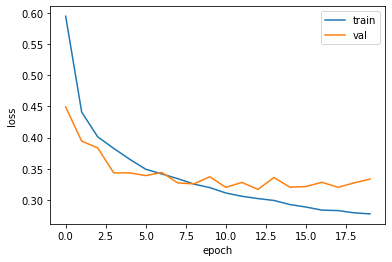

In [17]:
# *** 훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하면 안됨.
# *텐서플로와 케라스는 모델을 평가와 예측을 사용할 때는 자동으로 드롭아웃을 적용하지 않음.
model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
    # 과대적합이 확실히 줄었으나 열 번째 에포크 정도에서 검증 손실의 감소가 멈추지만 크게 상승하지 않고 어느정도 유지됨 
    # 20번의 에포크 동안 훈련을 했기 때문에 결국 다소 과대적합 되어 있음. 다시 에포크 10으로 훈련

In [18]:
# 모델 저장과 복원
# 에포크 횟수를 10으로 다시 지정하고 모델을 훈련하는데 먼저 이 모델을 저장해야 함.
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0,
                    validation_data=(val_scaled, val_target))

# 케라스 모델은 훈련된 모델의 파라미터를 저장하는 간편한 save_weights() 메서드를 제공함.
# 기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장함.
# 그러나 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장함.
model.save_weights('model-weights.h5')

# 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공
# 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장함.
model.save('model-whole.h5')

# 파일이 잘 만들어졌는지 확인
!ls -al *.h5   # 셀 명령을 실행할 떄 !를 사용함.

-rw-r--r-- 1 root root 332480 Jul 29 23:40 model-weights.h5
-rw-r--r-- 1 root root 981736 Jul 29 23:40 model-whole.h5


In [19]:
# 두 가지 실험 진행
# 실험 1. 훈련을 하지 않은 새로운 모델을 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용
# 실험 2. model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용

# 실험 1: 훈련하지 않은 모델을 만들고 이전에 저장했던 모델 파라미터를 적재
#   이때 사용하는 메서드는 save_weights()와 쌍을 이루는 load_weights() 메서드이다.
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

#   모델의 검증 정확도를 확인.
# 패션 MNIST 데이터셋에서 덜어낸 검증세트의 샘플 개수는 12,000개이기 때문에 predict()메서드는 (12000,10)크기의 배열을 반환함
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
    # predict() 메서드 결과에서 가장 큰 값을 고르기 위해 넘파이 argmax() 함수를 사용함
    # argmax() 함수의 axis=-1은 배열의 마지막 차원을 따라 최댓값을 고름
    #   axis=1이면 열을 따라 각 행의 최댓값의 인덱스를 선택
    #   axis=0이면 행을 따라 각 열의 최댓값의 인덱스
print(np.mean(val_labels == val_target))

0.8801666666666667


In [20]:
# 모델 전체를 파일에서 읽은 다음 검증 세트의 정확도를 출력해 봄
    # 모델이 저장된 파일을 읽을 때는 케라스가 제공하는 load_model()함수를 사용함
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3260 - accuracy: 0.8802


[0.32600271701812744, 0.8801666498184204]

In [21]:
# 결과적으로 실험 1과 실험 2의 정확도는 같은 모델을 저장하고 다시 불러들였기 때문에 위와 동일한 정확도를 얻음

# 앞선 모델은 20번의 에포크 동안 과대적합되어 다시 에포크 10으로 훈련
# 모델을 두번 훈련하지 않고 한 번에 끝낼수 있는 방법???


# 콜백(callback): 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들
#   fit() 메ㅐ서드의 callbacks 매개변수에 리스트로 전달하여 사용
#   ModelCheckpoint 콜백은 기본적으로 최상의 검증 점수를 만드는 모델을 저장.
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])